<a href="https://colab.research.google.com/github/P2Enjoy/ia-web3.fr/blob/main/VAE_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import diffusers
from torch.nn import functional as F
from PIL import Image, ImageDraw, ImageFont
import diffusers
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def make_comparisson(images, labels):
    header = 200
    total_w = sum([im.width for im in images])
    canvas = Image.new("RGB", (total_w, images[0].height + header))

    left_ptr = 0
    for im in images:
        canvas.paste(im, (left_ptr,header))
        left_ptr = left_ptr + im.width

    # write labels in header
    draw = ImageDraw.Draw(canvas)

    initial_midpoint_w = images[0].width // 2 - 25
    midpoint_w = initial_midpoint_w
    for lab in labels:
        midpoint_w_2 = images[0].width + initial_midpoint_w
        midpoint_h = header // 2 - 25
        # large text
        draw.text((midpoint_w, midpoint_h), lab, fill="white", font_size=140)
        midpoint_w = midpoint_w + images[0].width
    return canvas


In [ ]:
device = "cuda"
dtype = torch.float32
vae = diffusers.AutoencoderKL.from_pretrained("Lykon/DreamShaper", subfolder="vae").to(device, dtype)

[2024-02-01 16:05:23,250] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [ ]:
img = Image.open("./00000.png")
import torchvision.transforms as T
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])

In [ ]:
# transform PIL image into torch tensor
img_tensor = transforms(img).unsqueeze(0).to(device, dtype)

# vae encode
with torch.no_grad():
    vae_out = vae.encode(img_tensor)

# get the vae latent distriution
latent_dist = vae_out.latent_dist

# print out some stats
print("Latent distribution logvar mean: ", latent_dist.logvar.mean())
print("Latent distribution logvar std: ", latent_dist.logvar.std())
print("Latent distribution logvar min: ", latent_dist.logvar.min())
print("Latent distribution logvar max: ", latent_dist.logvar.max())
print("**"*20)
print("Latent distribution mean mean: ", latent_dist.mean.mean())
print("Latent distribution mean std: ", latent_dist.mean.std())
print("Latent distribution mean min: ", latent_dist.mean.min())
print("Latent distribution mean max: ", latent_dist.mean.max())
print("**"*20)
print("Latent distribution std mean: ", latent_dist.std.mean())
print("Latent distribution std std: ", latent_dist.std.std())
print("Latent distribution std min: ", latent_dist.std.min())
print("Latent distribution std max: ", latent_dist.std.max())

Latent distribution logvar mean:  tensor(-18.2563, device='cuda:0')
Latent distribution logvar std:  tensor(2.9011, device='cuda:0')
Latent distribution logvar min:  tensor(-30., device='cuda:0')
Latent distribution logvar max:  tensor(-13.2424, device='cuda:0')
****************************************
Latent distribution mean mean:  tensor(-0.5649, device='cuda:0')
Latent distribution mean std:  tensor(4.8187, device='cuda:0')
Latent distribution mean min:  tensor(-53.2928, device='cuda:0')
Latent distribution mean max:  tensor(46.8928, device='cuda:0')
****************************************
Latent distribution std mean:  tensor(0.0002, device='cuda:0')
Latent distribution std std:  tensor(0.0002, device='cuda:0')
Latent distribution std min:  tensor(3.0590e-07, device='cuda:0')
Latent distribution std max:  tensor(0.0013, device='cuda:0')


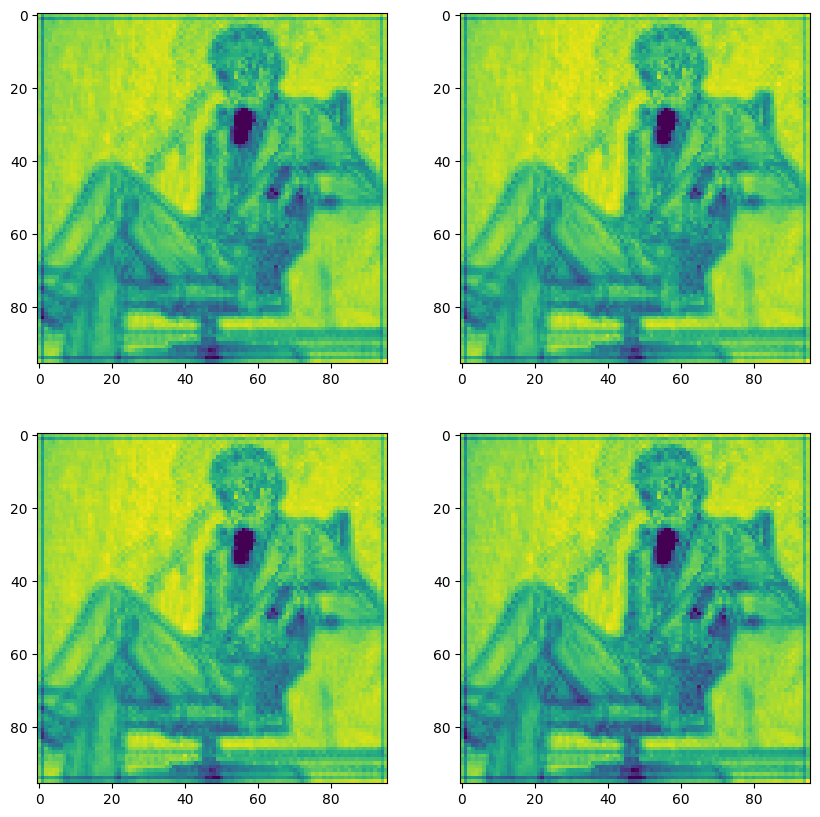

In [ ]:
# this is the logvar per channel, what was originall shown by OP
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(latent_dist.logvar[0,0].detach().cpu())
axs[0, 1].imshow(latent_dist.logvar[0,1].detach().cpu())
axs[1, 0].imshow(latent_dist.logvar[0,2].detach().cpu())
axs[1, 1].imshow(latent_dist.logvar[0,3].detach().cpu())


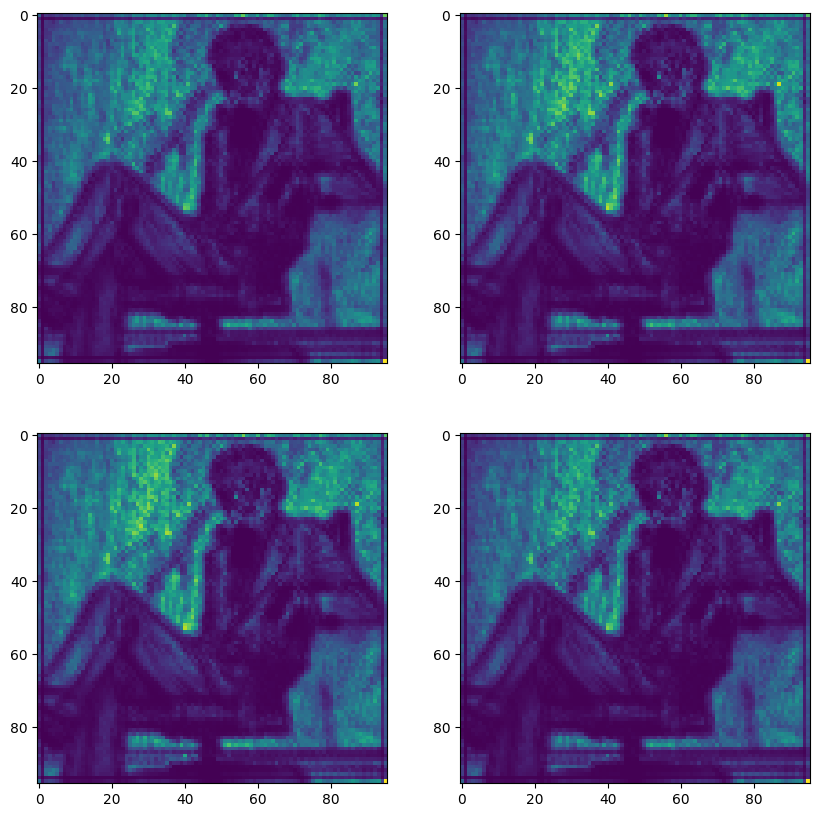

In [ ]:
# we can also plot the std, which is the e raise to the power of the square root of the logvar
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(latent_dist.std[0,0].detach().cpu())
axs[0, 1].imshow(latent_dist.std[0,1].detach().cpu())
axs[1, 0].imshow(latent_dist.std[0,2].detach().cpu())
axs[1, 1].imshow(latent_dist.std[0,3].detach().cpu())

In [ ]:
# the black hole zones of log var all are -30
# across all channels and the whole region
print(latent_dist.logvar[0,0,30, 56])
print(latent_dist.logvar[0,1,30, 56])
print(latent_dist.logvar[0,2,30, 56])
print(latent_dist.logvar[0,3,30, 56])


print(latent_dist.logvar[0,0,31, 56])
print(latent_dist.logvar[0,0,31, 55])

tensor(-30., device='cuda:0')
tensor(-30., device='cuda:0')
tensor(-30., device='cuda:0')
tensor(-30., device='cuda:0')
tensor(-30., device='cuda:0')
tensor(-30., device='cuda:0')


In [ ]:
# now i will raise the values to something near its neighbors
latent_dist.logvar[0,:,26:37, 53:60] = latent_dist.logvar[0,:,26:37, 53:60] + 8

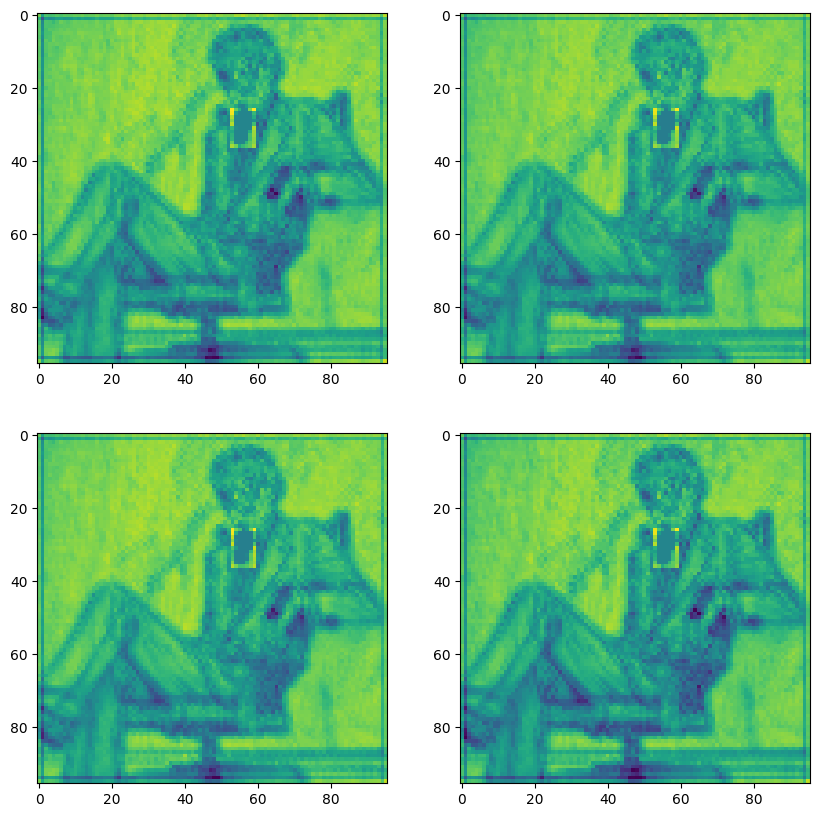

In [ ]:
# lets plot again
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(latent_dist.logvar[0,0].detach().cpu())
axs[0, 1].imshow(latent_dist.logvar[0,1].detach().cpu())
axs[1, 0].imshow(latent_dist.logvar[0,2].detach().cpu())
axs[1, 1].imshow(latent_dist.logvar[0,3].detach().cpu())

In [ ]:
# accordingly update the std
latent_dist.std = torch.exp(0.5 * latent_dist.logvar)
# alternatively we can mnanually sample too but just to do it through typical implementation
sample = latent_dist.sample()

In [ ]:
# decode back to pixel space
decoded = vae.decode(sample).sample
decoded = (decoded + 1) / 2
decoded = decoded.clamp(0, 1)
decoded = T.ToPILImage()(decoded[0])

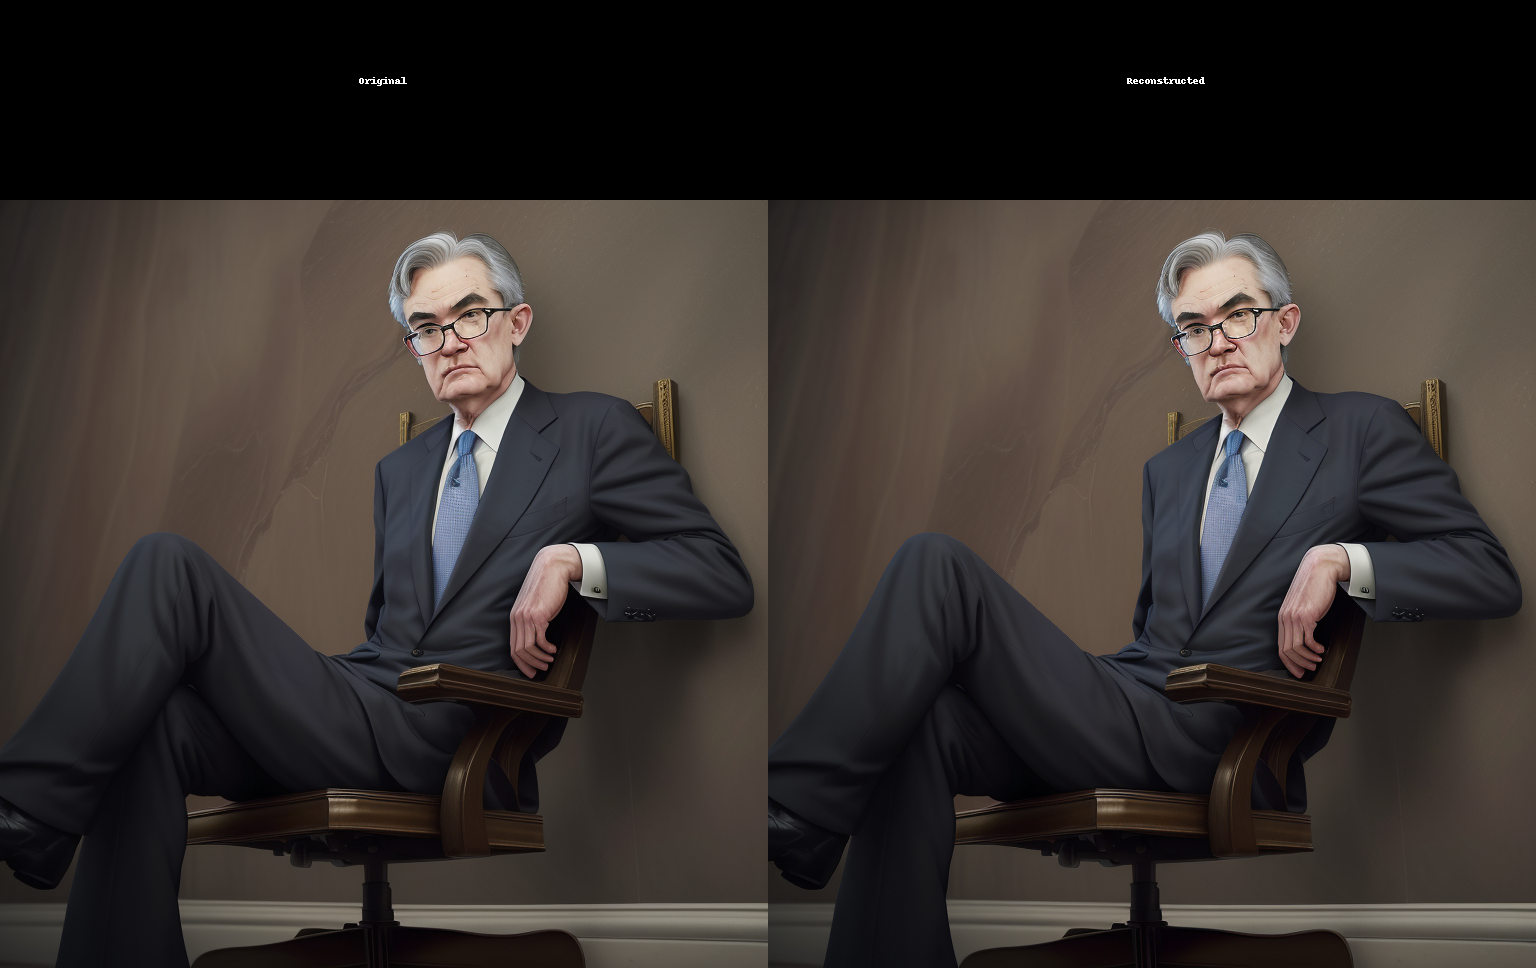

In [ ]:
make_comparisson([img, decoded], ["Original", "Reconstructed"])

In [ ]:
img_tensor = transforms(img)
decoded_tensor = transforms(decoded)
diff = torch.abs(img_tensor - decoded_tensor).mean()
print("Mean absolute difference: ", diff.item())
mse_diff = F.mse_loss(img_tensor, decoded_tensor)
print("MSE difference: ", mse_diff.item())

Mean absolute difference:  0.00874163955450058
MSE difference:  0.00044977167272008955


In [ ]:
# now lets try reconstructing with only the mean prediction, we can avoid making use of logvar entirely!
mean_decoded = vae.decode(latent_dist.mean).sample
mean_decoded = (mean_decoded + 1) / 2
mean_decoded = mean_decoded.clamp(0, 1)
mean_decoded = T.ToPILImage()(mean_decoded[0])


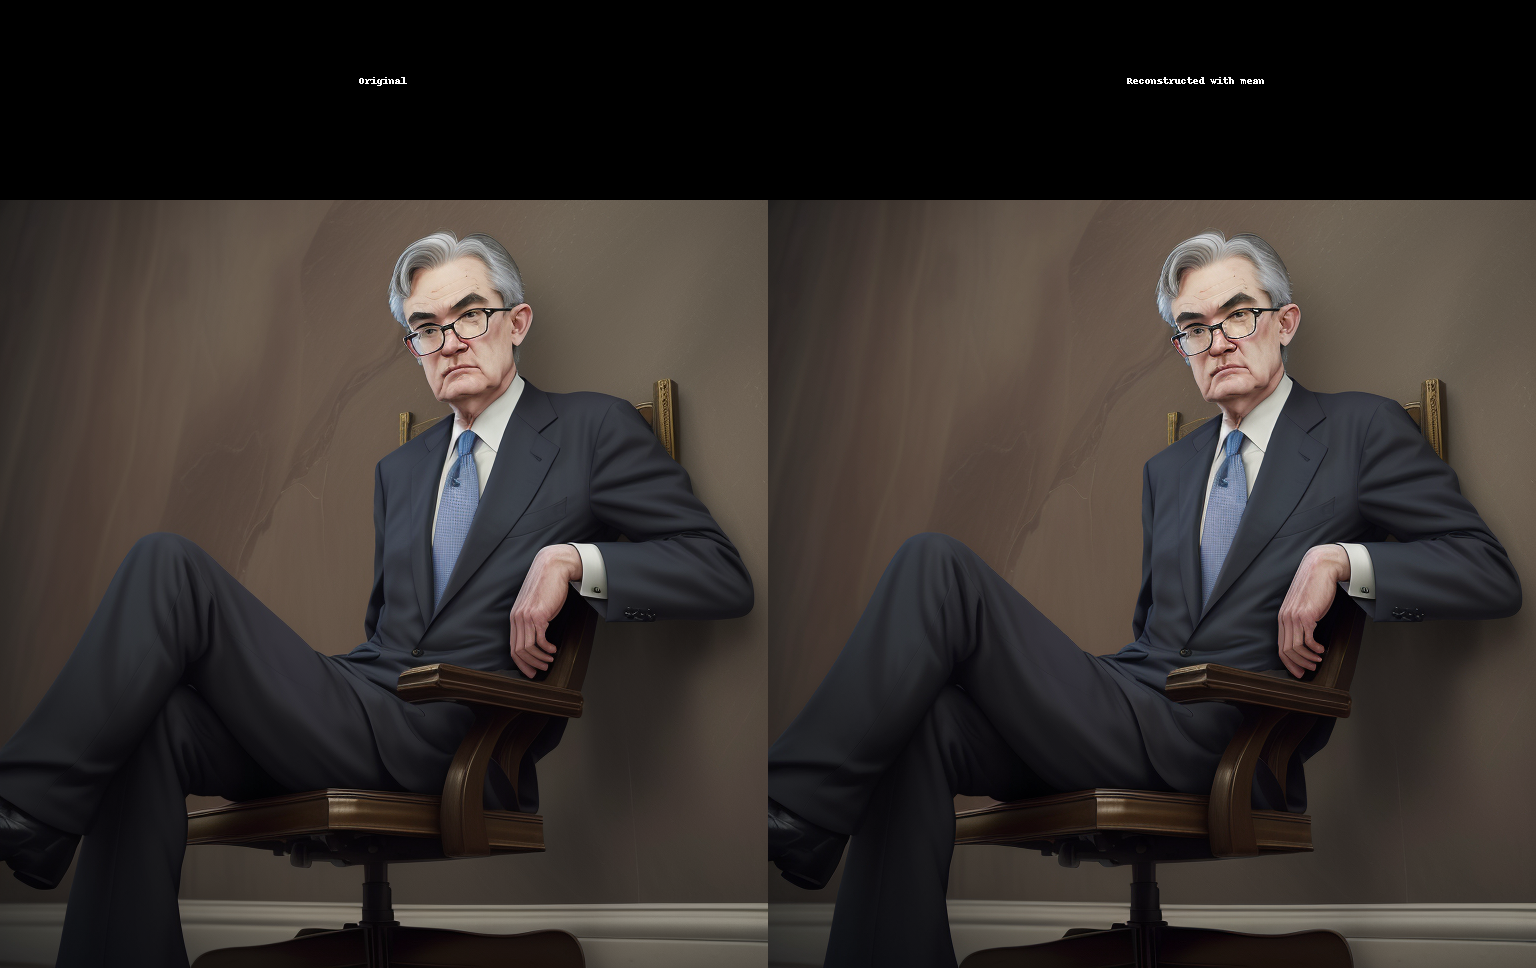

In [ ]:
make_comparisson([img, mean_decoded], ["Original", "Reconstructed with mean"])

In [ ]:
img_tensor = transforms(img)
decoded_tensor = transforms(mean_decoded)
diff = torch.abs(img_tensor - decoded_tensor).mean()
print("Mean absolute difference: ", diff.item())
mse_diff = F.mse_loss(img_tensor, decoded_tensor)
print("MSE difference: ", mse_diff.item())

Mean absolute difference:  0.008741902187466621
MSE difference:  0.0004498028720263392


tensor(0.0004)